Please create a folder named `data` in the main directory and place the following files inside it:

- `Reddit-Threads_2020-2021.csv`
- `Reddit-Threads_2022-2023.csv`

In [1]:
# Standard Library Imports
import os
import json
import time
import random
from dotenv import load_dotenv

# Data Handling
import pandas as pd
import numpy as np
from datasets import Dataset

# NLP and Transformers
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from nltk.corpus import stopwords
import torch
import torch.nn as nn
from sklearn.metrics import f1_score, precision_score, recall_score

# API and Hugging Face Integration
import requests
from huggingface_hub import login

# AI APIs
import google.generativeai as genai
from googleapiclient import discovery
from openai import OpenAI

# Visualization
import matplotlib.pyplot as plt

# Utilities
from tqdm import tqdm
import ast

# huggingface API key
hf_api_key = os.getenv('HUGGINGFACE_API_KEY')
login(token=hf_api_key)

if torch.cuda.is_available():
    device = torch.device("cuda")
    device_name = torch.cuda.get_device_name(torch.cuda.current_device())
    print(f'Device in use: {device_name}')
else:
    device = torch.device("cpu")
    print('Device in use: CPU')

load_dotenv()

c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to C:\Users\caboo\.cache\huggingface\token
Login successful
Device in use: NVIDIA GeForce RTX 3080 Laptop GPU


True

# Reading in data

In [2]:
df = pd.DataFrame()

###   SMALL DATASET   ###
# df = pd.read_csv('data/Reddit-Threads_2020-2021.csv', nrows=10000)
# print(df.head())
###   SMALL DATASET   ###

###   FULL DATASET   ###
# chunk_size = 10000
# for chunk in pd.read_csv('data/Reddit-Threads_2020-2021.csv', chunksize=chunk_size):
#     print(chunk.head())  
#     df = pd.concat([df, chunk])
# for chunk in pd.read_csv('data/Reddit-Threads_2022-2023.csv', chunksize=chunk_size):
#     print(chunk.head())  
#     df = pd.concat([df, chunk])
###   FULL DATASET   ###

###   VALIDATION DATASET   ###
df = pd.read_csv('data/labeled_data_2.csv')
df['combined'] = df['hateful'] | df['toxic']
print(df.head())

print(df.shape)


                                                text        timestamp  \
0     Expensive eh now that Uglyfoods closed down :(   30/1/2023 1:04   
1                How dare you.. wan go lim kopi ah??   4/5/2022 18:57   
2  Yeah the governments can politick all they wan...  28/6/2022 13:44   
3               Hijacks event, then complains. Wild.   12/7/2022 7:29   
4  Hate to break it to you. But once someone accu...   23/8/2023 2:08   

              username                                               link  \
0      MangoDangoLango  /r/singapore/comments/10nqt5h/rsingapore_rando...   
1               900122  /r/SingaporeRaw/comments/ui0rmg/dont_take_offe...   
2  DisillusionedSinkie  /r/singapore/comments/vmb197/malaysias_top_tal...   
3            nehjipain  /r/singapore/comments/vx42x1/nus_student_tried...   
4          KeenStudent  /r/singapore/comments/15ybdme/sorry_doesnt_cut...   

      link_id   parent_id       id subreddit_id  \
0  t3_10nqt5h  t1_j6dwxo8  j6fuv4x     t5_2qh8c

# Cleaning

In [3]:
# df['moderation'] = df['moderation'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
# moderation_dicts = df['moderation']
# moderation_normalized = pd.json_normalize(moderation_dicts)
# # print(moderation_normalized)
# df = df.reset_index(drop=True)
# moderation_normalized = moderation_normalized.reset_index(drop=True)
# df_normalized = pd.concat([df.drop(columns=['moderation']), moderation_normalized], axis=1)
# # print(df_normalized.columns)
df_normalized = df

### removing deleted or removed text ###
df_normalized = df_normalized[df_normalized['text'] != '[deleted]']
df_normalized = df_normalized[df_normalized['text'] != '[removed]']
df_normalized = df_normalized.dropna(subset=['text'])
### removing deleted or removed text ###

### stop word removal ###
# stop_words = set(stopwords.words('english'))

# def remove_stop_words(text):
#     if isinstance(text, str):  # Check if the text is a string
#         return ' '.join([word for word in text.split() if word.lower() not in stop_words])
#     return text 

# df_normalized['text'] = df_normalized['text'].apply(remove_stop_words)
# print(df_normalized['text'])
# print(stop_words)
### stop word removal ###



# 2 Finding the best labeller
https://huggingface.co/sileod/deberta-v3-base-tasksource-toxicity

after testing with the following models:<br>
with the threshold at 0 meaning 100% True or if not 1 False and 299 True<br>
As sileod/deberta-v3-base-tasksource-toxicity has a relatively high f1 score and a takes a relatively low time to label the text data, we decided to use it. <br>
| models                                                                          |   best toxic f1_score |   toxic threshold |   best hate f1_score |   hate threshold |   combined best f1 score |   combined threshold  | time taken   |
|----------------------------------------------------------------------------------|----------------------:|------------------:|---------------------:|-----------------:|-------------------------:|----------------------:|:-------------|
| sileod/deberta-v3-base-tasksource-toxicity                                       |             0.547368  |              0.01 |             0.573034 |             0.04 |                 0.675079 |                  0.01 | 11s          |
| unitary/toxic-bert                                                               |             0.543689  |              0    |             0.513889 |             0.40 |                 0.648649 |                  0    | 4s           |
| GroNLP/hateBERT                                                                  |             0.545012  |              0.38 |             0.411552 |             0.72 |                 0.648649 |                  0    | 4s           |
| textdetox/xlmr-large-toxicity-classifier                                         |             0.540146  |              0    |             0.493671 |             0.05 |                 0.645598 |                  0    | 4s           |
| facebook/roberta-hate-speech-dynabench-r4-target                                 |             0.540146  |              0    |             0.42236  |             0.04 |                 0.645598 |                  0    | 4s           |
| cointegrated/rubert-tiny-toxicity                                                |             0.540146  |              0    |             0.429268 |             0.04 |                 0.645598 |                  0    | 1s           |
| badmatr11x/distilroberta-base-offensive-hateful-speech-text-multiclassification  |             0.540146  |              0    |             0.391421 |             0    |                 0.645598 |                  0    | 2s           |
| citizenlab/distilbert-base-multilingual-cased-toxicity                           |             0.540146  |              0    |             0.48062  |             0.57 |                 0.645598 |                  0    | 7s           |
| meta-llama/Llama-3.2-1B-Instruct                                                 |             0.0610687 |            nan    |             0.14     |           nan    |                 0.27027  |                nan    | 27s          |
| meta-llama/Llama-3.2-3B-Instruct                                                 |             0.46875   |            nan    |             0.342342 |           nan    |                 0.497778 |                nan    | 12min 7s     |
| aisingapore/llama3-8b-cpt-sea-lionv2.1-instruct                                  |             0.514286  |            nan    |             0.324786 |           nan    |                 0.517857 |                nan    | 1h 40mins    |
| Perspective API                                                                  |             0.289157  |            nan    |             0.289157 |           nan    |                 0.424242 |                nan    | 6mins 20s    |
| GANgstersDev/singlish-hate-offensive-finetuned-model-v2.0.1                      |             0.50411   |            nan    |             0.385321 |           nan    |                 0.604534 |                nan    | 15s          |
| Hate-speech-CNERG/dehatebert-mono-english                                        |             0.543689  |              0    |             0.47619  |             0.08 |                 0.648649 |                  0    | 5s           |
| cardiffnlp/twitter-roberta-base-hate                                             |             0.540146  |              0    |             0.423077 |             0.04 |                 0.645598 |                  0    | 5s           |
| Hate-speech-CNERG/bert-base-uncased-hatexplain                                   |             0.574468  |              0.73 |             0.476744 |             0.67 |                 0.660661 |                  0.74 | 7s           |
| mrm8488/distilroberta-finetuned-tweets-hate-speech                               |             0.556122  |              0.04 |             0.391421 |             0    |                 0.646226 |                  0.04 | 3s           |


## 2.1 Trying Bert models

### 2.1.1 sileod/deberta-v3-base-tasksource-toxicity

In [44]:
# Choose model here
model = 'sileod/deberta-v3-base-tasksource-toxicity'

# Initialize the hate classifier
pipe = pipeline("text-classification", model=model, return_all_scores=True, device=device)

# Create a list to store the predicted scores for each text
df_normalized['temp_score'] = np.nan  # To store the hate score

test_response = pipe("I hate you")
# import pdb; pdb.set_trace()

# Process the texts and save the prediction scores
for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying:"):
    text = row['text']
    
    # Skip invalid texts
    if not isinstance(text, str) or text.strip() == "":
        print(f"Invalid text at index {index}. Skipping row.")
        continue

    try:
        # Get predictions from pipe
        prediction = pipe(text)
        
        # Extract the score for 'hate' label
        for pred in prediction[0]:
            label = pred['label']
            score = pred['score']
            if label == 'hate':  # CHECK THE LABEL HERE
                df_normalized.at[index, 'temp_score'] = score
                break

    except Exception as e:
        print(f"Error processing hate speech at index {index}: {e}")

# Function to calculate F1 score for different thresholds and true label columns
def calculate_f1_for_threshold(df, threshold, true_labels):
    # Predict 'True' for hate if the score is above the threshold
    predicted_labels = df['temp_score'].apply(lambda x: True if x >= threshold else False)
    return f1_score(true_labels, predicted_labels)

# List of columns to compare against
label_columns = ['toxic', 'hateful', 'combined']

# Dictionary to store the best thresholds and F1 scores for each column
best_results = {}

# Iterate over each label column ('toxic', 'hateful', 'combined')
for label_column in label_columns:
    true_labels = df_normalized[label_column]
    
    best_threshold = 0
    best_f1 = 0
    
    # Search for the best threshold by calculating F1 score for different thresholds
    thresholds = np.linspace(0, 1, 101)  # Try thresholds between 0 and 1 in 0.01 increments
    
    for threshold in thresholds:
        f1 = calculate_f1_for_threshold(df_normalized, threshold, true_labels)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    # Store the results for this label column
    best_results[label_column] = {'Best Threshold': best_threshold, 'Best F1 Score': best_f1}

    print(f"Best Threshold for {label_column}: {best_threshold}, Best F1 Score: {best_f1}")

# Apply the best threshold for each label column to label texts as hateful or not
for label_column in label_columns:
    best_threshold = best_results[label_column]['Best Threshold']
    df_normalized[f'temp_{label_column}'] = df_normalized['temp_score'] >= best_threshold

# Print the final counts of hateful and non-hateful texts for each label column
for label_column in label_columns:
    print(f"\nCounts for {label_column}:")
    print(df_normalized[f'temp_{label_column}'].value_counts())

del pipe


c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Classifying:: 100%|██████████| 300/300 [00:12<00:00, 24.97it/s]


Best Threshold for toxic: 0.01, Best F1 Score: 0.5473684210526316
Best Threshold for hateful: 0.04, Best F1 Score: 0.5730337078651685
Best Threshold for combined: 0.01, Best F1 Score: 0.6750788643533123

Counts for toxic:
temp_toxic
True     173
False    127
Name: count, dtype: int64

Counts for hateful:
temp_hateful
False    196
True     104
Name: count, dtype: int64

Counts for combined:
temp_combined
True     173
False    127
Name: count, dtype: int64


In [45]:
# Choose model here
model = 'sileod/deberta-v3-base-tasksource-toxicity'

# Initialize the hate classifier
pipe = pipeline("text-classification", model=model, return_all_scores=True, device=device)

# Create a list to store the predicted scores for each text
df_normalized['temp_score'] = np.nan  # To store the hate score

test_response = pipe("I hate you")
# import pdb; pdb.set_trace()

# Process the texts and save the prediction scores
for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying:"):
    text = row['text']
    
    # Skip invalid texts
    if not isinstance(text, str) or text.strip() == "":
        print(f"Invalid text at index {index}. Skipping row.")
        continue

    try:
        # Get predictions from pipe
        prediction = pipe(text)
        
        # Extract the score for 'hate' label
        for pred in prediction[0]:
            label = pred['label']
            score = pred['score']
            if label == 'hate':  # CHECK THE LABEL HERE
                df_normalized.at[index, 'temp_score'] = score
                break

    except Exception as e:
        print(f"Error processing hate speech at index {index}: {e}")

c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Classifying:: 100%|██████████| 300/300 [00:11<00:00, 25.57it/s]


In [46]:
# Count the number of rows where 'temp_score' is less than 0.2
count_below_0_2 = df_normalized[df_normalized['temp_score'] >= 0.8].shape[0]

# Print the count
print(f"Number of rows with 'temp_score' less than 0.2: {count_below_0_2}")


Number of rows with 'temp_score' less than 0.2: 26


In [72]:
# Create a new column 'toxicity_label' based on the conditions for 'temp_score'
df_normalized['toxicity_label'] = df_normalized['temp_score'].apply(
    lambda x: 'toxic' if x >= 0.1 else ('not toxic' if x < 0.2 else 'ambiguous')
)

# Print the first few rows to verify the new column
print(df_normalized[['temp_score', 'toxicity_label']].head())


   temp_score toxicity_label
0    0.008786      not toxic
1    0.005781      not toxic
2    0.003931      not toxic
3    0.008570      not toxic
4    0.094989      not toxic


In [66]:
# Relabel the 'combined' column based on the condition
df_normalized['combined_label'] = df_normalized['combined'].apply(lambda x: 'toxic' if x else 'not toxic')

# Print the first few rows to verify the new column
print(df_normalized[['combined', 'combined_label']].head())


   combined combined_label
0     False      not toxic
1     False      not toxic
2     False      not toxic
3     False      not toxic
4     False      not toxic


In [73]:
print(f1_score(df_normalized['combined_label'], df_normalized['toxicity_label'], average='weighted'))   

0.6207944220919543


KeyError: 1

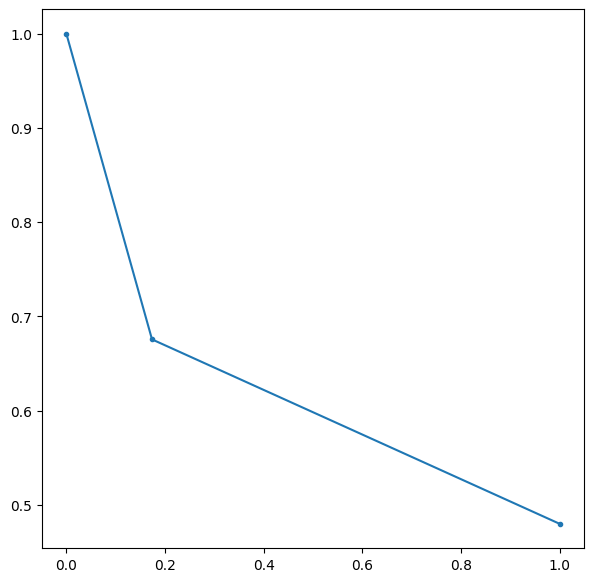

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.preprocessing import label_binarize

# Step 1: Map 'combined_label' and 'toxicity_label' into numeric values
# toxic = 2, not toxic = 1, ambiguous = 1
label_mapping = {'toxic': 2, 'not toxic': 0, 'ambiguous': 1}
y_true = df_normalized['combined_label'].map(label_mapping)
y_pred = df_normalized['toxicity_label'].map(label_mapping)

# Step 2: Binarize the output labels for precision-recall calculation
# This converts the multiclass problem into multiple binary problems
y_true_binarized = label_binarize(y_true, classes=[1, 2])  # 'not toxic', 'ambiguous' vs 'toxic'
y_pred_binarized = label_binarize(y_pred, classes=[1, 2])

# Step 3: Compute precision, recall, and thresholds for each class
precision = dict()
recall = dict()

# Only considering two classes: toxic (2) vs others (1)
for i in range(y_true_binarized.shape[1]):
    precision[i], recall[i], _ = precision_recall_curve(y_true_binarized[:, i], y_pred_binarized[:, i])

# Step 4: Plot precision-recall curve for each class
plt.figure(figsize=(7, 7))
plt.plot(recall[0], precision[0], marker='.', label='Not Toxic/Ambiguous vs Toxic')
plt.plot(recall[1], precision[1], marker='.', label='Ambiguous vs Toxic')

# Step 5: Customize and show the plot
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Multiclass)')
plt.legend()
plt.grid(True)
plt.show()

# Calculate and print F1 score (weighted) for multiclass
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score (weighted): {f1}")


In [19]:
# Choose model here
model = 'sileod/deberta-v3-base-tasksource-toxicity'

# Initialize the hate classifier
pipe = pipeline("text-classification", model=model, return_all_scores=True, device=device)

# Create a list to store the predicted scores for each text
df_normalized['temp_score'] = np.nan  # To store the hate score
df_normalized['temp_label'] = False  # To store the hate label
# Create a list to store the actual hate labels (for F1 score calculation)
true_labels =  df_normalized['toxic'] 
true_labels = df_normalized['hateful']
true_labels = df_normalized['combined']

test_response = pipe("I hate you")
# import pdb; pdb.set_trace()

# Process the texts and save the prediction scores
for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying:"):
    text = row['text']
    
    # Skip invalid texts
    if not isinstance(text, str) or text.strip() == "":
        print(f"Invalid text at index {index}. Skipping row.")
        continue

    try:
        # Get predictions from pipe
        prediction = pipe(text)
        
        # Extract the score for 'hate' label
        for pred in prediction[0]:
            label = pred['label']
            score = pred['score']
            if label == 'hate' and score >= 0.71:  # CHECK THE LABEL HERE
                df_normalized.at[index, 'temp_label'] = True 
                break

    except Exception as e:
        print(f"Error processing hate speech at index {index}: {e}")

# Function to calculate F1 score for different thresholds
# def calculate_f1_for_threshold(df, threshold):
#     # Predict 'True' for hate if the score is above the threshold
#     predicted_labels = df['temp_score'].apply(lambda x: True if x < threshold else False)
#     return f1_score(true_labels, predicted_labels)

# Search for the best threshold by calculating F1 score for different thresholds
# thresholds = np.linspace(0, 1, 101)  # Try thresholds between 0 and 1 in 0.01 increments
# best_threshold = 0
# best_f1 = 0

# for threshold in thresholds:
#     f1 = calculate_f1_for_threshold(df_normalized, threshold)
#     if f1 > best_f1:
#         best_f1 = f1
#         best_threshold = threshold

# print(f"Best Threshold: {best_threshold}, Best F1 Score: {best_f1}")

# # Apply the best threshold to label texts as hateful or not
# df_normalized['temp'] = df_normalized['temp_score'] < best_threshold

print(f1_score(true_labels, df_normalized['temp_label']))
print(precision_score(true_labels, df_normalized['temp_label']))
print(recall_score(true_labels, df_normalized['temp_label']))

# Print the final counts of hateful and non-hateful texts
print(df_normalized['temp_label'].value_counts())

del pipe

c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Classifying:: 100%|██████████| 300/300 [00:12<00:00, 23.10it/s]

0.34065934065934067
0.8157894736842105
0.2152777777777778
temp_label
False    262
True      38
Name: count, dtype: int64


### 2.1.2 unitary/toxic-bert

In [9]:
# Choose model here
model = 'unitary/toxic-bert'

# Initialize the hate classifier
pipe = pipeline("text-classification", model=model, return_all_scores=True, device=device)

# Create a list to store the predicted scores for each text
df_normalized['temp_score'] = np.nan  # To store the hate score

test_response = pipe("I hate you")
# import pdb; pdb.set_trace()

# Process the texts and save the prediction scores
for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying:"):
    text = row['text']
    
    # Skip invalid texts
    if not isinstance(text, str) or text.strip() == "":
        print(f"Invalid text at index {index}. Skipping row.")
        continue

    try:
        # Get predictions from pipe
        prediction = pipe(text)
        
        # Extract the score for 'hate' label
        for pred in prediction[0]:
            label = pred['label']
            score = pred['score']
            if label == 'toxic':  # CHECK THE LABEL HERE
                df_normalized.at[index, 'temp_score'] = score
                break

    except Exception as e:
        print(f"Error processing hate speech at index {index}: {e}")

# Function to calculate F1 score for different thresholds and true label columns
def calculate_f1_for_threshold(df, threshold, true_labels):
    # Predict 'True' for hate if the score is above the threshold
    predicted_labels = df['temp_score'].apply(lambda x: True if x >= threshold else False)
    return f1_score(true_labels, predicted_labels)

# List of columns to compare against
label_columns = ['toxic', 'hateful', 'combined']

# Dictionary to store the best thresholds and F1 scores for each column
best_results = {}

# Iterate over each label column ('toxic', 'hateful', 'combined')
for label_column in label_columns:
    true_labels = df_normalized[label_column]
    
    best_threshold = 0
    best_f1 = 0
    
    # Search for the best threshold by calculating F1 score for different thresholds
    thresholds = np.linspace(0, 1, 101)  # Try thresholds between 0 and 1 in 0.01 increments
    
    for threshold in thresholds:
        f1 = calculate_f1_for_threshold(df_normalized, threshold, true_labels)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    # Store the results for this label column
    best_results[label_column] = {'Best Threshold': best_threshold, 'Best F1 Score': best_f1}

    print(f"Best Threshold for {label_column}: {best_threshold}, Best F1 Score: {best_f1}")

# Apply the best threshold for each label column to label texts as hateful or not
for label_column in label_columns:
    best_threshold = best_results[label_column]['Best Threshold']
    df_normalized[f'temp_{label_column}'] = df_normalized['temp_score'] >= best_threshold

# Print the final counts of hateful and non-hateful texts for each label column
for label_column in label_columns:
    print(f"\nCounts for {label_column}:")
    print(df_normalized[f'temp_{label_column}'].value_counts())

del pipe


c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Classifying:: 100%|██████████| 300/300 [00:04<00:00, 63.10it/s]


Best Threshold for toxic: 0.0, Best F1 Score: 0.5436893203883495
Best Threshold for hateful: 0.4, Best F1 Score: 0.5138888888888888
Best Threshold for combined: 0.0, Best F1 Score: 0.6486486486486487

Counts for toxic:
temp_toxic
True    300
Name: count, dtype: int64

Counts for hateful:
temp_hateful
False    230
True      70
Name: count, dtype: int64

Counts for combined:
temp_combined
True    300
Name: count, dtype: int64


### 2.1.3 GroNLP/hateBERT (loves to fluctuate .-.)

In [13]:
# Choose model here
model = 'GroNLP/hateBERT'

# Initialize the hate classifier
pipe = pipeline("text-classification", model=model, return_all_scores=True, device=device)

# Create a list to store the predicted scores for each text
df_normalized['temp_score'] = np.nan  # To store the hate score

test_response = pipe("I hate you")
# import pdb; pdb.set_trace()

# Process the texts and save the prediction scores
for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying:"):
    text = row['text']
    
    # Skip invalid texts
    if not isinstance(text, str) or text.strip() == "":
        print(f"Invalid text at index {index}. Skipping row.")
        continue

    try:
        # Get predictions from pipe
        prediction = pipe(text)
        
        # Extract the score for 'hate' label
        for pred in prediction[0]:
            label = pred['label']
            score = pred['score']
            if label == 'LABEL_0':  # CHECK THE LABEL HERE
                df_normalized.at[index, 'temp_score'] = score
                break

    except Exception as e:
        print(f"Error processing hate speech at index {index}: {e}")

# Function to calculate F1 score for different thresholds and true label columns
def calculate_f1_for_threshold(df, threshold, true_labels):
    # Predict 'True' for hate if the score is above the threshold
    predicted_labels = df['temp_score'].apply(lambda x: True if x >= threshold else False)
    return f1_score(true_labels, predicted_labels)

# List of columns to compare against
label_columns = ['toxic', 'hateful', 'combined']

# Dictionary to store the best thresholds and F1 scores for each column
best_results = {}

# Iterate over each label column ('toxic', 'hateful', 'combined')
for label_column in label_columns:
    true_labels = df_normalized[label_column]
    
    best_threshold = 0
    best_f1 = 0
    
    # Search for the best threshold by calculating F1 score for different thresholds
    thresholds = np.linspace(0, 1, 101)  # Try thresholds between 0 and 1 in 0.01 increments
    
    for threshold in thresholds:
        f1 = calculate_f1_for_threshold(df_normalized, threshold, true_labels)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    # Store the results for this label column
    best_results[label_column] = {'Best Threshold': best_threshold, 'Best F1 Score': best_f1}

    print(f"Best Threshold for {label_column}: {best_threshold}, Best F1 Score: {best_f1}")

# Apply the best threshold for each label column to label texts as hateful or not
for label_column in label_columns:
    best_threshold = best_results[label_column]['Best Threshold']
    df_normalized[f'temp_{label_column}'] = df_normalized['temp_score'] >= best_threshold

# Print the final counts of hateful and non-hateful texts for each label column
for label_column in label_columns:
    print(f"\nCounts for {label_column}:")
    print(df_normalized[f'temp_{label_column}'].value_counts())

del pipe


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Classifying:: 100%|██████████| 300/300 [00:04<00:00, 68.97it/s]


Best Threshold for toxic: 0.4, Best F1 Score: 0.5544554455445545
Best Threshold for hateful: 0.38, Best F1 Score: 0.3978494623655914
Best Threshold for combined: 0.38, Best F1 Score: 0.6515837104072398

Counts for toxic:
temp_toxic
True     292
False      8
Name: count, dtype: int64

Counts for hateful:
temp_hateful
True     298
False      2
Name: count, dtype: int64

Counts for combined:
temp_combined
True     298
False      2
Name: count, dtype: int64


### 2.1.4 textdetox/xlmr-large-toxicity-classifier

In [15]:
# Choose model here
model = 'textdetox/xlmr-large-toxicity-classifier'

# Initialize the hate classifier
pipe = pipeline("text-classification", model=model, return_all_scores=True, device=device)

# Create a list to store the predicted scores for each text
df_normalized['temp_score'] = np.nan  # To store the hate score

test_response = pipe("I hate you")
# import pdb; pdb.set_trace()

# Process the texts and save the prediction scores
for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying:"):
    text = row['text']
    
    # Skip invalid texts
    if not isinstance(text, str) or text.strip() == "":
        print(f"Invalid text at index {index}. Skipping row.")
        continue

    try:
        # Get predictions from pipe
        prediction = pipe(text)
        
        # Extract the score for 'hate' label
        for pred in prediction[0]:
            label = pred['label']
            score = pred['score']
            if label == 'toxic':  # CHECK THE LABEL HERE
                df_normalized.at[index, 'temp_score'] = score
                break

    except Exception as e:
        print(f"Error processing hate speech at index {index}: {e}")

# Function to calculate F1 score for different thresholds and true label columns
def calculate_f1_for_threshold(df, threshold, true_labels):
    # Predict 'True' for hate if the score is above the threshold
    predicted_labels = df['temp_score'].apply(lambda x: True if x >= threshold else False)
    return f1_score(true_labels, predicted_labels)

# List of columns to compare against
label_columns = ['toxic', 'hateful', 'combined']

# Dictionary to store the best thresholds and F1 scores for each column
best_results = {}

# Iterate over each label column ('toxic', 'hateful', 'combined')
for label_column in label_columns:
    true_labels = df_normalized[label_column]
    
    best_threshold = 0
    best_f1 = 0
    
    # Search for the best threshold by calculating F1 score for different thresholds
    thresholds = np.linspace(0, 1, 101)  # Try thresholds between 0 and 1 in 0.01 increments
    
    for threshold in thresholds:
        f1 = calculate_f1_for_threshold(df_normalized, threshold, true_labels)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    # Store the results for this label column
    best_results[label_column] = {'Best Threshold': best_threshold, 'Best F1 Score': best_f1}

    print(f"Best Threshold for {label_column}: {best_threshold}, Best F1 Score: {best_f1}")

# Apply the best threshold for each label column to label texts as hateful or not
for label_column in label_columns:
    best_threshold = best_results[label_column]['Best Threshold']
    df_normalized[f'temp_{label_column}'] = df_normalized['temp_score'] >= best_threshold

# Print the final counts of hateful and non-hateful texts for each label column
for label_column in label_columns:
    print(f"\nCounts for {label_column}:")
    print(df_normalized[f'temp_{label_column}'].value_counts())

del pipe


Classifying::  44%|████▍     | 132/300 [00:01<00:02, 61.33it/s]

Error processing hate speech at index 121: The expanded size of the tensor (547) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 547].  Tensor sizes: [1, 514]


Classifying:: 100%|██████████| 300/300 [00:04<00:00, 67.10it/s]


Best Threshold for toxic: 0.0, Best F1 Score: 0.5401459854014599
Best Threshold for hateful: 0.05, Best F1 Score: 0.4936708860759494
Best Threshold for combined: 0.0, Best F1 Score: 0.6455981941309256

Counts for toxic:
temp_toxic
True     299
False      1
Name: count, dtype: int64

Counts for hateful:
temp_hateful
False    216
True      84
Name: count, dtype: int64

Counts for combined:
temp_combined
True     299
False      1
Name: count, dtype: int64


### 2.1.5 facebook/roberta-hate-speech-dynabench-r4-target

In [17]:
# Choose model here
model = 'facebook/roberta-hate-speech-dynabench-r4-target'

# Initialize the hate classifier
pipe = pipeline("text-classification", model=model, return_all_scores=True, device=device)

# Create a list to store the predicted scores for each text
df_normalized['temp_score'] = np.nan  # To store the hate score

test_response = pipe("I hate you")
# import pdb; pdb.set_trace()

# Process the texts and save the prediction scores
for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying:"):
    text = row['text']
    
    # Skip invalid texts
    if not isinstance(text, str) or text.strip() == "":
        print(f"Invalid text at index {index}. Skipping row.")
        continue

    try:
        # Get predictions from pipe
        prediction = pipe(text)
        
        # Extract the score for 'hate' label
        for pred in prediction[0]:
            label = pred['label']
            score = pred['score']
            if label == 'hate':  # CHECK THE LABEL HERE
                df_normalized.at[index, 'temp_score'] = score
                break

    except Exception as e:
        print(f"Error processing hate speech at index {index}: {e}")

# Function to calculate F1 score for different thresholds and true label columns
def calculate_f1_for_threshold(df, threshold, true_labels):
    # Predict 'True' for hate if the score is above the threshold
    predicted_labels = df['temp_score'].apply(lambda x: True if x >= threshold else False)
    return f1_score(true_labels, predicted_labels)

# List of columns to compare against
label_columns = ['toxic', 'hateful', 'combined']

# Dictionary to store the best thresholds and F1 scores for each column
best_results = {}

# Iterate over each label column ('toxic', 'hateful', 'combined')
for label_column in label_columns:
    true_labels = df_normalized[label_column]
    
    best_threshold = 0
    best_f1 = 0
    
    # Search for the best threshold by calculating F1 score for different thresholds
    thresholds = np.linspace(0, 1, 101)  # Try thresholds between 0 and 1 in 0.01 increments
    
    for threshold in thresholds:
        f1 = calculate_f1_for_threshold(df_normalized, threshold, true_labels)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    # Store the results for this label column
    best_results[label_column] = {'Best Threshold': best_threshold, 'Best F1 Score': best_f1}

    print(f"Best Threshold for {label_column}: {best_threshold}, Best F1 Score: {best_f1}")

# Apply the best threshold for each label column to label texts as hateful or not
for label_column in label_columns:
    best_threshold = best_results[label_column]['Best Threshold']
    df_normalized[f'temp_{label_column}'] = df_normalized['temp_score'] >= best_threshold

# Print the final counts of hateful and non-hateful texts for each label column
for label_column in label_columns:
    print(f"\nCounts for {label_column}:")
    print(df_normalized[f'temp_{label_column}'].value_counts())

del pipe


Classifying::  43%|████▎     | 130/300 [00:02<00:02, 66.51it/s]

Error processing hate speech at index 121: The expanded size of the tensor (532) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 532].  Tensor sizes: [1, 514]


Classifying:: 100%|██████████| 300/300 [00:04<00:00, 64.87it/s]


Best Threshold for toxic: 0.0, Best F1 Score: 0.5401459854014599
Best Threshold for hateful: 0.04, Best F1 Score: 0.422360248447205
Best Threshold for combined: 0.0, Best F1 Score: 0.6455981941309256

Counts for toxic:
temp_toxic
True     299
False      1
Name: count, dtype: int64

Counts for hateful:
temp_hateful
False    213
True      87
Name: count, dtype: int64

Counts for combined:
temp_combined
True     299
False      1
Name: count, dtype: int64


### 2.1.6 cointegrated/rubert-tiny-toxicity 

In [21]:
# Choose model here
model = 'cointegrated/rubert-tiny-toxicity'

# Initialize the hate classifier
pipe = pipeline("text-classification", model=model, return_all_scores=True, device=device)

# Create a list to store the predicted scores for each text
df_normalized['temp_score'] = np.nan  # To store the hate score

test_response = pipe("I hate you")
# import pdb; pdb.set_trace()

# Process the texts and save the prediction scores
for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying:"):
    text = row['text']
    
    # Skip invalid texts
    if not isinstance(text, str) or text.strip() == "":
        print(f"Invalid text at index {index}. Skipping row.")
        continue

    try:
        # Get predictions from pipe
        prediction = pipe(text)
        
        # Extract the score for 'hate' label
        for pred in prediction[0]:
            label = pred['label']
            score = pred['score']
            if label == 'non-toxic':  # CHECK THE LABEL HERE
                df_normalized.at[index, 'temp_score'] = score
                break

    except Exception as e:
        print(f"Error processing hate speech at index {index}: {e}")

# Function to calculate F1 score for different thresholds and true label columns
def calculate_f1_for_threshold(df, threshold, true_labels):
    # Predict 'True' for hate if the score is above the threshold
    predicted_labels = df['temp_score'].apply(lambda x: True if x < threshold else False)
    return f1_score(true_labels, predicted_labels)

# List of columns to compare against
label_columns = ['toxic', 'hateful', 'combined']

# Dictionary to store the best thresholds and F1 scores for each column
best_results = {}

# Iterate over each label column ('toxic', 'hateful', 'combined')
for label_column in label_columns:
    true_labels = df_normalized[label_column]
    
    best_threshold = 0
    best_f1 = 0
    
    # Search for the best threshold by calculating F1 score for different thresholds
    thresholds = np.linspace(0, 1, 101)  # Try thresholds between 0 and 1 in 0.01 increments
    
    for threshold in thresholds:
        f1 = calculate_f1_for_threshold(df_normalized, threshold, true_labels)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    # Store the results for this label column
    best_results[label_column] = {'Best Threshold': best_threshold, 'Best F1 Score': best_f1}

    print(f"Best Threshold for {label_column}: {best_threshold}, Best F1 Score: {best_f1}")

# Apply the best threshold for each label column to label texts as hateful or not
for label_column in label_columns:
    best_threshold = best_results[label_column]['Best Threshold']
    df_normalized[f'temp_{label_column}'] = df_normalized['temp_score'] < best_threshold

# Print the final counts of hateful and non-hateful texts for each label column
for label_column in label_columns:
    print(f"\nCounts for {label_column}:")
    print(df_normalized[f'temp_{label_column}'].value_counts())

del pipe


Classifying::  50%|█████     | 150/300 [00:00<00:00, 161.23it/s]

Error processing hate speech at index 121: The size of tensor a (553) must match the size of tensor b (512) at non-singleton dimension 1


Classifying:: 100%|██████████| 300/300 [00:01<00:00, 155.87it/s]


Best Threshold for toxic: 1.0, Best F1 Score: 0.5401459854014599
Best Threshold for hateful: 0.96, Best F1 Score: 0.4292682926829268
Best Threshold for combined: 1.0, Best F1 Score: 0.6455981941309256

Counts for toxic:
temp_toxic
True     299
False      1
Name: count, dtype: int64

Counts for hateful:
temp_hateful
False    169
True     131
Name: count, dtype: int64

Counts for combined:
temp_combined
True     299
False      1
Name: count, dtype: int64


### 2.1.7 badmatr11x/distilroberta-base-offensive-hateful-speech-text-multiclassification

In [24]:
# Choose model here
model = 'badmatr11x/distilroberta-base-offensive-hateful-speech-text-multiclassification'

# Initialize the hate classifier
pipe = pipeline("text-classification", model=model, return_all_scores=True, device=device)

# Create a list to store the predicted scores for each text
df_normalized['temp_score'] = np.nan  # To store the hate score

test_response = pipe("I hate you")
# import pdb; pdb.set_trace()

# Process the texts and save the prediction scores
for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying:"):
    text = row['text']
    
    # Skip invalid texts
    if not isinstance(text, str) or text.strip() == "":
        print(f"Invalid text at index {index}. Skipping row.")
        continue

    try:
        # Get predictions from pipe
        prediction = pipe(text)
        
        # Extract the score for 'hate' label
        for pred in prediction[0]:
            label = pred['label']
            score = pred['score']
            if label == 'NEITHER':  # CHECK THE LABEL HERE
                df_normalized.at[index, 'temp_score'] = score
                break

    except Exception as e:
        print(f"Error processing hate speech at index {index}: {e}")

# Function to calculate F1 score for different thresholds and true label columns
def calculate_f1_for_threshold(df, threshold, true_labels):
    # Predict 'True' for hate if the score is above the threshold
    predicted_labels = df['temp_score'].apply(lambda x: True if x < threshold else False)
    return f1_score(true_labels, predicted_labels)

# List of columns to compare against
label_columns = ['toxic', 'hateful', 'combined']

# Dictionary to store the best thresholds and F1 scores for each column
best_results = {}

# Iterate over each label column ('toxic', 'hateful', 'combined')
for label_column in label_columns:
    true_labels = df_normalized[label_column]
    
    best_threshold = 0
    best_f1 = 0
    
    # Search for the best threshold by calculating F1 score for different thresholds
    thresholds = np.linspace(0, 1, 101)  # Try thresholds between 0 and 1 in 0.01 increments
    
    for threshold in thresholds:
        f1 = calculate_f1_for_threshold(df_normalized, threshold, true_labels)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    # Store the results for this label column
    best_results[label_column] = {'Best Threshold': best_threshold, 'Best F1 Score': best_f1}

    print(f"Best Threshold for {label_column}: {best_threshold}, Best F1 Score: {best_f1}")

# Apply the best threshold for each label column to label texts as hateful or not
for label_column in label_columns:
    best_threshold = best_results[label_column]['Best Threshold']
    df_normalized[f'temp_{label_column}'] = df_normalized['temp_score'] < best_threshold

# Print the final counts of hateful and non-hateful texts for each label column
for label_column in label_columns:
    print(f"\nCounts for {label_column}:")
    print(df_normalized[f'temp_{label_column}'].value_counts())

del pipe


Classifying::  48%|████▊     | 145/300 [00:01<00:01, 112.67it/s]

Error processing hate speech at index 121: The expanded size of the tensor (532) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 532].  Tensor sizes: [1, 514]


Classifying:: 100%|██████████| 300/300 [00:02<00:00, 104.67it/s]


Best Threshold for toxic: 1.0, Best F1 Score: 0.5401459854014599
Best Threshold for hateful: 1.0, Best F1 Score: 0.3914209115281501
Best Threshold for combined: 1.0, Best F1 Score: 0.6455981941309256

Counts for toxic:
temp_toxic
True     299
False      1
Name: count, dtype: int64

Counts for hateful:
temp_hateful
True     299
False      1
Name: count, dtype: int64

Counts for combined:
temp_combined
True     299
False      1
Name: count, dtype: int64


### 2.1.8 citizenlab/distilbert-base-multilingual-cased-toxicity

In [27]:
# Choose model here
model = 'citizenlab/distilbert-base-multilingual-cased-toxicity'

# Initialize the hate classifier
pipe = pipeline("text-classification", model=model, return_all_scores=True, device=device)

# Create a list to store the predicted scores for each text
df_normalized['temp_score'] = np.nan  # To store the hate score

test_response = pipe("I hate you")
# import pdb; pdb.set_trace()

# Process the texts and save the prediction scores
for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying:"):
    text = row['text']
    
    # Skip invalid texts
    if not isinstance(text, str) or text.strip() == "":
        print(f"Invalid text at index {index}. Skipping row.")
        continue

    try:
        # Get predictions from pipe
        prediction = pipe(text)
        
        # Extract the score for 'hate' label
        for pred in prediction[0]:
            label = pred['label']
            score = pred['score']
            if label == 'toxic':  # CHECK THE LABEL HERE
                df_normalized.at[index, 'temp_score'] = score
                break

    except Exception as e:
        print(f"Error processing hate speech at index {index}: {e}")

# Function to calculate F1 score for different thresholds and true label columns
def calculate_f1_for_threshold(df, threshold, true_labels):
    # Predict 'True' for hate if the score is above the threshold
    predicted_labels = df['temp_score'].apply(lambda x: True if x >= threshold else False)
    return f1_score(true_labels, predicted_labels)

# List of columns to compare against
label_columns = ['toxic', 'hateful', 'combined']

# Dictionary to store the best thresholds and F1 scores for each column
best_results = {}

# Iterate over each label column ('toxic', 'hateful', 'combined')
for label_column in label_columns:
    true_labels = df_normalized[label_column]
    
    best_threshold = 0
    best_f1 = 0
    
    # Search for the best threshold by calculating F1 score for different thresholds
    thresholds = np.linspace(0, 1, 101)  # Try thresholds between 0 and 1 in 0.01 increments
    
    for threshold in thresholds:
        f1 = calculate_f1_for_threshold(df_normalized, threshold, true_labels)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    # Store the results for this label column
    best_results[label_column] = {'Best Threshold': best_threshold, 'Best F1 Score': best_f1}

    print(f"Best Threshold for {label_column}: {best_threshold}, Best F1 Score: {best_f1}")

# Apply the best threshold for each label column to label texts as hateful or not
for label_column in label_columns:
    best_threshold = best_results[label_column]['Best Threshold']
    df_normalized[f'temp_{label_column}'] = df_normalized['temp_score'] >= best_threshold

# Print the final counts of hateful and non-hateful texts for each label column
for label_column in label_columns:
    print(f"\nCounts for {label_column}:")
    print(df_normalized[f'temp_{label_column}'].value_counts())

del pipe


c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Classifying::  45%|████▌     | 135/300 [00:01<00:01, 103.71it/s]

Error processing hate speech at index 121: The size of tensor a (553) must match the size of tensor b (512) at non-singleton dimension 1


Classifying:: 100%|██████████| 300/300 [00:03<00:00, 98.71it/s] 


Best Threshold for toxic: 0.0, Best F1 Score: 0.5401459854014599
Best Threshold for hateful: 0.5700000000000001, Best F1 Score: 0.4806201550387597
Best Threshold for combined: 0.0, Best F1 Score: 0.6455981941309256

Counts for toxic:
temp_toxic
True     299
False      1
Name: count, dtype: int64

Counts for hateful:
temp_hateful
False    245
True      55
Name: count, dtype: int64

Counts for combined:
temp_combined
True     299
False      1
Name: count, dtype: int64


### 2.1.9 GANgstersDev/singlish-hate-offensive-finetuned-model-v2.0.1 <br> 
class_labels = ["neither", "offensive", "hate"] 

In [30]:
# Choose model here
model = 'GANgstersDev/singlish-hate-offensive-finetuned-model-v2.0.1'

# Initialize the hate classifier
pipe = pipeline("text-classification", model=model, return_all_scores=True, device=device)

# Create a list to store the predicted scores for each text
df_normalized['temp_score'] = np.nan  # To store the hate score

test_response = pipe("I hate you")
# import pdb; pdb.set_trace()

# Process the texts and save the prediction scores
for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying:"):
    text = row['text']
    
    # Skip invalid texts
    if not isinstance(text, str) or text.strip() == "":
        print(f"Invalid text at index {index}. Skipping row.")
        continue

    try:
        # Get predictions from pipe
        prediction = pipe(text)
        
        # Extract the score for 'hate' label
        for pred in prediction[0]:
            label = pred['label']
            score = pred['score']
            if label == 'LABEL_2':  # CHECK THE LABEL HERE
                df_normalized.at[index, 'temp_score'] = score
                break

    except Exception as e:
        print(f"Error processing hate speech at index {index}: {e}")

# Function to calculate F1 score for different thresholds and true label columns
def calculate_f1_for_threshold(df, threshold, true_labels):
    # Predict 'True' for hate if the score is above the threshold
    predicted_labels = df['temp_score'].apply(lambda x: True if x >= threshold else False)
    return f1_score(true_labels, predicted_labels)

# List of columns to compare against
label_columns = ['toxic', 'hateful', 'combined']

# Dictionary to store the best thresholds and F1 scores for each column
best_results = {}

# Iterate over each label column ('toxic', 'hateful', 'combined')
for label_column in label_columns:
    true_labels = df_normalized[label_column]
    
    best_threshold = 0
    best_f1 = 0
    
    # Search for the best threshold by calculating F1 score for different thresholds
    thresholds = np.linspace(0, 1, 101)  # Try thresholds between 0 and 1 in 0.01 increments
    
    for threshold in thresholds:
        f1 = calculate_f1_for_threshold(df_normalized, threshold, true_labels)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    # Store the results for this label column
    best_results[label_column] = {'Best Threshold': best_threshold, 'Best F1 Score': best_f1}

    print(f"Best Threshold for {label_column}: {best_threshold}, Best F1 Score: {best_f1}")

# Apply the best threshold for each label column to label texts as hateful or not
for label_column in label_columns:
    best_threshold = best_results[label_column]['Best Threshold']
    df_normalized[f'temp_{label_column}'] = df_normalized['temp_score'] >= best_threshold

# Print the final counts of hateful and non-hateful texts for each label column
for label_column in label_columns:
    print(f"\nCounts for {label_column}:")
    print(df_normalized[f'temp_{label_column}'].value_counts())

del pipe


Classifying:: 100%|██████████| 300/300 [00:03<00:00, 78.49it/s]


Best Threshold for toxic: 0.0, Best F1 Score: 0.5436893203883495
Best Threshold for hateful: 0.0, Best F1 Score: 0.39572192513368987
Best Threshold for combined: 0.0, Best F1 Score: 0.6486486486486487

Counts for toxic:
temp_toxic
True    300
Name: count, dtype: int64

Counts for hateful:
temp_hateful
True    300
Name: count, dtype: int64

Counts for combined:
temp_combined
True    300
Name: count, dtype: int64


### 2.1.10 Hate-speech-CNERG/dehatebert-mono-english

In [35]:
# Choose model here
model = 'Hate-speech-CNERG/dehatebert-mono-english'

# Initialize the hate classifier
pipe = pipeline("text-classification", model=model, return_all_scores=True, device=device)

# Create a list to store the predicted scores for each text
df_normalized['temp_score'] = np.nan  # To store the hate score

test_response = pipe("I hate you")
# import pdb; pdb.set_trace()

# Process the texts and save the prediction scores
for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying:"):
    text = row['text']
    
    # Skip invalid texts
    if not isinstance(text, str) or text.strip() == "":
        print(f"Invalid text at index {index}. Skipping row.")
        continue

    try:
        # Get predictions from pipe
        prediction = pipe(text)
        
        # Extract the score for 'hate' label
        for pred in prediction[0]:
            label = pred['label']
            score = pred['score']
            if label == 'HATE':  # CHECK THE LABEL HERE
                df_normalized.at[index, 'temp_score'] = score
                break

    except Exception as e:
        print(f"Error processing hate speech at index {index}: {e}")

# Function to calculate F1 score for different thresholds and true label columns
def calculate_f1_for_threshold(df, threshold, true_labels):
    # Predict 'True' for hate if the score is above the threshold
    predicted_labels = df['temp_score'].apply(lambda x: True if x >= threshold else False)
    return f1_score(true_labels, predicted_labels)

# List of columns to compare against
label_columns = ['toxic', 'hateful', 'combined']

# Dictionary to store the best thresholds and F1 scores for each column
best_results = {}

# Iterate over each label column ('toxic', 'hateful', 'combined')
for label_column in label_columns:
    true_labels = df_normalized[label_column]
    
    best_threshold = 0
    best_f1 = 0
    
    # Search for the best threshold by calculating F1 score for different thresholds
    thresholds = np.linspace(0, 1, 101)  # Try thresholds between 0 and 1 in 0.01 increments
    
    for threshold in thresholds:
        f1 = calculate_f1_for_threshold(df_normalized, threshold, true_labels)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    # Store the results for this label column
    best_results[label_column] = {'Best Threshold': best_threshold, 'Best F1 Score': best_f1}

    print(f"Best Threshold for {label_column}: {best_threshold}, Best F1 Score: {best_f1}")

# Apply the best threshold for each label column to label texts as hateful or not
for label_column in label_columns:
    best_threshold = best_results[label_column]['Best Threshold']
    df_normalized[f'temp_{label_column}'] = df_normalized['temp_score'] >= best_threshold

# Print the final counts of hateful and non-hateful texts for each label column
for label_column in label_columns:
    print(f"\nCounts for {label_column}:")
    print(df_normalized[f'temp_{label_column}'].value_counts())

del pipe


c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Classifying:: 100%|██████████| 300/300 [00:04<00:00, 69.48it/s]


Best Threshold for toxic: 0.0, Best F1 Score: 0.5436893203883495
Best Threshold for hateful: 0.08, Best F1 Score: 0.47619047619047616
Best Threshold for combined: 0.0, Best F1 Score: 0.6486486486486487

Counts for toxic:
temp_toxic
True    300
Name: count, dtype: int64

Counts for hateful:
temp_hateful
False    206
True      94
Name: count, dtype: int64

Counts for combined:
temp_combined
True    300
Name: count, dtype: int64


### 2.1.11 cardiffnlp/twitter-roberta-base-hate

In [38]:
# Choose model here
model = 'cardiffnlp/twitter-roberta-base-hate'

# Initialize the hate classifier
pipe = pipeline("text-classification", model=model, return_all_scores=True, device=device)

# Create a list to store the predicted scores for each text
df_normalized['temp_score'] = np.nan  # To store the hate score

test_response = pipe("I hate you")
# import pdb; pdb.set_trace()

# Process the texts and save the prediction scores
for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying:"):
    text = row['text']
    
    # Skip invalid texts
    if not isinstance(text, str) or text.strip() == "":
        print(f"Invalid text at index {index}. Skipping row.")
        continue

    try:
        # Get predictions from pipe
        prediction = pipe(text)
        
        # Extract the score for 'hate' label
        for pred in prediction[0]:
            label = pred['label']
            score = pred['score']
            if label == 'hate':  # CHECK THE LABEL HERE
                df_normalized.at[index, 'temp_score'] = score
                break

    except Exception as e:
        print(f"Error processing hate speech at index {index}: {e}")

# Function to calculate F1 score for different thresholds and true label columns
def calculate_f1_for_threshold(df, threshold, true_labels):
    # Predict 'True' for hate if the score is above the threshold
    predicted_labels = df['temp_score'].apply(lambda x: True if x >= threshold else False)
    return f1_score(true_labels, predicted_labels)

# List of columns to compare against
label_columns = ['toxic', 'hateful', 'combined']

# Dictionary to store the best thresholds and F1 scores for each column
best_results = {}

# Iterate over each label column ('toxic', 'hateful', 'combined')
for label_column in label_columns:
    true_labels = df_normalized[label_column]
    
    best_threshold = 0
    best_f1 = 0
    
    # Search for the best threshold by calculating F1 score for different thresholds
    thresholds = np.linspace(0, 1, 101)  # Try thresholds between 0 and 1 in 0.01 increments
    
    for threshold in thresholds:
        f1 = calculate_f1_for_threshold(df_normalized, threshold, true_labels)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    # Store the results for this label column
    best_results[label_column] = {'Best Threshold': best_threshold, 'Best F1 Score': best_f1}

    print(f"Best Threshold for {label_column}: {best_threshold}, Best F1 Score: {best_f1}")

# Apply the best threshold for each label column to label texts as hateful or not
for label_column in label_columns:
    best_threshold = best_results[label_column]['Best Threshold']
    df_normalized[f'temp_{label_column}'] = df_normalized['temp_score'] >= best_threshold

# Print the final counts of hateful and non-hateful texts for each label column
for label_column in label_columns:
    print(f"\nCounts for {label_column}:")
    print(df_normalized[f'temp_{label_column}'].value_counts())

del pipe


Classifying::  44%|████▍     | 132/300 [00:02<00:02, 66.87it/s]

Error processing hate speech at index 121: The expanded size of the tensor (532) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 532].  Tensor sizes: [1, 514]


Classifying:: 100%|██████████| 300/300 [00:04<00:00, 64.18it/s]


Best Threshold for toxic: 0.0, Best F1 Score: 0.5401459854014599
Best Threshold for hateful: 0.04, Best F1 Score: 0.4230769230769231
Best Threshold for combined: 0.0, Best F1 Score: 0.6455981941309256

Counts for toxic:
temp_toxic
True     299
False      1
Name: count, dtype: int64

Counts for hateful:
temp_hateful
True     186
False    114
Name: count, dtype: int64

Counts for combined:
temp_combined
True     299
False      1
Name: count, dtype: int64


### 2.1.12 Hate-speech-CNERG/bert-base-uncased-hatexplain

In [40]:
# Choose model here
model = 'Hate-speech-CNERG/bert-base-uncased-hatexplain'

# Initialize the hate classifier
pipe = pipeline("text-classification", model=model, return_all_scores=True, device=device)

# Create a list to store the predicted scores for each text
df_normalized['temp_score'] = np.nan  # To store the hate score

test_response = pipe("I hate you")
# import pdb; pdb.set_trace()

# Process the texts and save the prediction scores
for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying:"):
    text = row['text']
    
    # Skip invalid texts
    if not isinstance(text, str) or text.strip() == "":
        print(f"Invalid text at index {index}. Skipping row.")
        continue

    try:
        # Get predictions from pipe
        prediction = pipe(text)
        
        # Extract the score for 'hate' label
        for pred in prediction[0]:
            label = pred['label']
            score = pred['score']
            if label == 'hate speech':  # CHECK THE LABEL HERE
                df_normalized.at[index, 'temp_score'] = score
                break

    except Exception as e:
        print(f"Error processing hate speech at index {index}: {e}")

# Function to calculate F1 score for different thresholds and true label columns
def calculate_f1_for_threshold(df, threshold, true_labels):
    # Predict 'True' for hate if the score is above the threshold
    predicted_labels = df['temp_score'].apply(lambda x: True if x >= threshold else False)
    return f1_score(true_labels, predicted_labels)

# List of columns to compare against
label_columns = ['toxic', 'hateful', 'combined']

# Dictionary to store the best thresholds and F1 scores for each column
best_results = {}

# Iterate over each label column ('toxic', 'hateful', 'combined')
for label_column in label_columns:
    true_labels = df_normalized[label_column]
    
    best_threshold = 0
    best_f1 = 0
    
    # Search for the best threshold by calculating F1 score for different thresholds
    thresholds = np.linspace(0, 1, 101)  # Try thresholds between 0 and 1 in 0.01 increments
    
    for threshold in thresholds:
        f1 = calculate_f1_for_threshold(df_normalized, threshold, true_labels)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    # Store the results for this label column
    best_results[label_column] = {'Best Threshold': best_threshold, 'Best F1 Score': best_f1}

    print(f"Best Threshold for {label_column}: {best_threshold}, Best F1 Score: {best_f1}")

# Apply the best threshold for each label column to label texts as hateful or not
for label_column in label_columns:
    best_threshold = best_results[label_column]['Best Threshold']
    df_normalized[f'temp_{label_column}'] = df_normalized['temp_score'] >= best_threshold

# Print the final counts of hateful and non-hateful texts for each label column
for label_column in label_columns:
    print(f"\nCounts for {label_column}:")
    print(df_normalized[f'temp_{label_column}'].value_counts())

del pipe


Classifying:: 100%|██████████| 300/300 [00:06<00:00, 48.63it/s]


Best Threshold for toxic: 0.04, Best F1 Score: 0.5714285714285714
Best Threshold for hateful: 0.04, Best F1 Score: 0.4444444444444444
Best Threshold for combined: 0.04, Best F1 Score: 0.6588235294117647

Counts for toxic:
temp_toxic
True     196
False    104
Name: count, dtype: int64

Counts for hateful:
temp_hateful
True     196
False    104
Name: count, dtype: int64

Counts for combined:
temp_combined
True     196
False    104
Name: count, dtype: int64


### 2.1.13 mrm8488/distilroberta-finetuned-tweets-hate-speech

In [43]:
# Choose model here
model = 'mrm8488/distilroberta-finetuned-tweets-hate-speech'

# Initialize the hate classifier
pipe = pipeline("text-classification", model=model, return_all_scores=True, device=device)

# Create a list to store the predicted scores for each text
df_normalized['temp_score'] = np.nan  # To store the hate score

test_response = pipe("I hate you")
# import pdb; pdb.set_trace()

# Process the texts and save the prediction scores
for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying:"):
    text = row['text']
    
    # Skip invalid texts
    if not isinstance(text, str) or text.strip() == "":
        print(f"Invalid text at index {index}. Skipping row.")
        continue

    try:
        # Get predictions from pipe
        prediction = pipe(text)
        
        # Extract the score for 'hate' label
        for pred in prediction[0]:
            label = pred['label']
            score = pred['score']
            if label == 'LABEL_0':  # CHECK THE LABEL HERE
                df_normalized.at[index, 'temp_score'] = score
                break

    except Exception as e:
        print(f"Error processing hate speech at index {index}: {e}")

# Function to calculate F1 score for different thresholds and true label columns
def calculate_f1_for_threshold(df, threshold, true_labels):
    # Predict 'True' for hate if the score is above the threshold
    predicted_labels = df['temp_score'].apply(lambda x: True if x >= threshold else False)
    return f1_score(true_labels, predicted_labels)

# List of columns to compare against
label_columns = ['toxic', 'hateful', 'combined']

# Dictionary to store the best thresholds and F1 scores for each column
best_results = {}

# Iterate over each label column ('toxic', 'hateful', 'combined')
for label_column in label_columns:
    true_labels = df_normalized[label_column]
    
    best_threshold = 0
    best_f1 = 0
    
    # Search for the best threshold by calculating F1 score for different thresholds
    thresholds = np.linspace(0, 1, 101)  # Try thresholds between 0 and 1 in 0.01 increments
    
    for threshold in thresholds:
        f1 = calculate_f1_for_threshold(df_normalized, threshold, true_labels)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    # Store the results for this label column
    best_results[label_column] = {'Best Threshold': best_threshold, 'Best F1 Score': best_f1}

    print(f"Best Threshold for {label_column}: {best_threshold}, Best F1 Score: {best_f1}")

# Apply the best threshold for each label column to label texts as hateful or not
for label_column in label_columns:
    best_threshold = best_results[label_column]['Best Threshold']
    df_normalized[f'temp_{label_column}'] = df_normalized['temp_score'] >= best_threshold

# Print the final counts of hateful and non-hateful texts for each label column
for label_column in label_columns:
    print(f"\nCounts for {label_column}:")
    print(df_normalized[f'temp_{label_column}'].value_counts())

del pipe


Classifying::  48%|████▊     | 143/300 [00:01<00:01, 117.82it/s]

Error processing hate speech at index 121: The expanded size of the tensor (532) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 532].  Tensor sizes: [1, 514]


Classifying:: 100%|██████████| 300/300 [00:02<00:00, 107.47it/s]


Best Threshold for toxic: 0.04, Best F1 Score: 0.5561224489795918
Best Threshold for hateful: 0.0, Best F1 Score: 0.3914209115281501
Best Threshold for combined: 0.04, Best F1 Score: 0.6462264150943396

Counts for toxic:
temp_toxic
True     280
False     20
Name: count, dtype: int64

Counts for hateful:
temp_hateful
True     299
False      1
Name: count, dtype: int64

Counts for combined:
temp_combined
True     280
False     20
Name: count, dtype: int64


## 2.2 testing Llama models

### 2.2.1 meta-llama/Llama-3.2-1B-Instruct

In [4]:
pipe = pipeline("text-generation", model='meta-llama/Llama-3.2-1B-Instruct', device_map='auto')

In [5]:
for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying toxicity and hatefulness"):
    text = row['text']
    messages = [
        {"role": "system", "content": "You are a moderator on the subreddit r/Singapore. You are reviewing a user's comment to determine if it is toxic or hateful. Please respond with only False (not toxic or hateful) or True (very toxic or hateful) for the following comment."},
        {"role": "user", "content": text},
    ]
    response = pipe(messages, max_new_tokens=50, do_sample=False, truncation=True)
    df_normalized.at[index, 'Llama_combined'] = (response[0]['generated_text'][2]['content'] == 'True')

df_normalized['Llama_combined'] = df_normalized['Llama_combined'].astype(bool)

Classifying toxicity and hatefulness:   0%|          | 0/300 [00:00<?, ?it/s]c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:606: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\models\llama\modeling_llama.py:655: UserWarning: 1Torch was not compiled with flash attention

In [6]:
for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying toxicity and hatefulness"):
    text = row['text']
    messages = [
        {"role": "system", "content": "You are a moderator on the subreddit r/Singapore. You are reviewing a user's comment to determine if it is toxic. Please respond with only False (not toxic) or True (very toxic) for the following comment."},
        {"role": "user", "content": text},
    ]
    response = pipe(messages, max_new_tokens=50, do_sample=False, truncation=True)
    df_normalized.at[index, 'Llama_toxic'] = (response[0]['generated_text'][2]['content'] == 'True')

df_normalized['Llama_toxic'] = df_normalized['Llama_toxic'].astype(bool)

Classifying toxicity and hatefulness:   0%|          | 0/300 [00:00<?, ?it/s]c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:606: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `

In [7]:
for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying toxicity and hatefulness"):
    text = row['text']
    messages = [
        {"role": "system", "content": "You are a moderator on the subreddit r/Singapore. You are reviewing a user's comment to determine if it is hateful. Please respond with only False (not hateful) or True (very hateful) for the following comment."},
        {"role": "user", "content": text},
    ]
    response = pipe(messages, max_new_tokens=50, do_sample=False, truncation=True)
    df_normalized.at[index, 'Llama_hate'] = (response[0]['generated_text'][2]['content'] == 'True')

df_normalized['Llama_hate'] = df_normalized['Llama_hate'].astype(bool)

Classifying toxicity and hatefulness:   0%|          | 0/300 [00:00<?, ?it/s]c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:606: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `

In [8]:
print(df_normalized['Llama_combined'].value_counts())
# print(df_normalized['combined'].value_counts())
f1 = f1_score(df_normalized['combined'], df_normalized['Llama_combined'], average='weighted')
print(f"F1 Score: {f1}")

print(df_normalized['Llama_toxic'].value_counts())
f1 = f1_score(df_normalized['toxic'], df_normalized['Llama_toxic'], average='weighted')
print(f"F1 Score: {f1}")

print(df_normalized['Llama_hate'].value_counts())
f1 = f1_score(df_normalized['hateful'], df_normalized['Llama_hate'], average='weighted')
print(f"F1 Score: {f1}")

Llama_combined
False    200
True     100
Name: count, dtype: int64
F1 Score: 0.4309707128384601
Llama_toxic
False    280
True      20
Name: count, dtype: int64
F1 Score: 0.4832530432530433
Llama_hate
False    259
True      41
Name: count, dtype: int64
F1 Score: 0.6634645151650979


In [9]:
del pipe

### 2.2.2 meta-llama/Llama-3.2-3B-Instruct

In [4]:
pipe = pipeline("text-generation", model='meta-llama/Llama-3.2-3B-Instruct', device_map='auto')

Loading checkpoint shards: 100%|██████████| 2/2 [00:08<00:00,  4.23s/it]
Some parameters are on the meta device because they were offloaded to the cpu.


In [5]:
for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying toxicity and hatefulness"):
    text = row['text']
    messages = [
        {"role": "system", "content": "You are a moderator on the subreddit r/Singapore. You are reviewing a user's comment to determine if it is toxic or hateful. Please respond with only False (not toxic or hateful) or True (very toxic or hateful) for the following comment."},
        {"role": "user", "content": text},
    ]
    response = pipe(messages, max_new_tokens=50, do_sample=False, truncation=True)
    df_normalized.at[index, 'Llama_combined'] = (response[0]['generated_text'][2]['content'] == 'True')

df_normalized['Llama_combined'] = df_normalized['Llama_combined'].astype(bool)

Classifying toxicity and hatefulness:   0%|          | 0/300 [00:00<?, ?it/s]c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:606: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\models\llama\modeling_llama.py:655: UserWarning: 1Torch was not compiled with flash attention

In [6]:
for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying toxicity and hatefulness"):
    text = row['text']
    messages = [
        {"role": "system", "content": "You are a moderator on the subreddit r/Singapore. You are reviewing a user's comment to determine if it is toxic. Please respond with only False (not toxic) or True (very toxic) for the following comment."},
        {"role": "user", "content": text},
    ]
    response = pipe(messages, max_new_tokens=50, do_sample=False, truncation=True)
    df_normalized.at[index, 'Llama_toxic'] = (response[0]['generated_text'][2]['content'] == 'True')

df_normalized['Llama_toxic'] = df_normalized['Llama_toxic'].astype(bool)

Classifying toxicity and hatefulness:   0%|          | 0/300 [00:00<?, ?it/s]c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:606: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Classifying toxicity and hatefulness:   0%|          | 1/300 [00:02<10:58,  2.20s/it]c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\generati

In [7]:
for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying toxicity and hatefulness"):
    text = row['text']
    messages = [
        {"role": "system", "content": "You are a moderator on the subreddit r/Singapore. You are reviewing a user's comment to determine if it is hateful. Please respond with only False (not hateful) or True (very hateful) for the following comment."},
        {"role": "user", "content": text},
    ]
    response = pipe(messages, max_new_tokens=50, do_sample=False, truncation=True)
    df_normalized.at[index, 'Llama_hate'] = (response[0]['generated_text'][2]['content'] == 'True')

df_normalized['Llama_hate'] = df_normalized['Llama_hate'].astype(bool)

Classifying toxicity and hatefulness:   0%|          | 0/300 [00:00<?, ?it/s]c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:606: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Classifying toxicity and hatefulness:   0%|          | 1/300 [00:02<11:05,  2.23s/it]c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\generati

In [8]:
print(df_normalized['Llama_combined'].value_counts())
# print(df_normalized['combined'].value_counts())
f1 = f1_score(df_normalized['combined'], df_normalized['Llama_combined'], average='weighted')
print(f"F1 Score: {f1}")

print(df_normalized['Llama_toxic'].value_counts())
f1 = f1_score(df_normalized['toxic'], df_normalized['Llama_toxic'], average='weighted')
print(f"F1 Score: {f1}")

print(df_normalized['Llama_hate'].value_counts())
f1 = f1_score(df_normalized['hateful'], df_normalized['Llama_hate'], average='weighted')
print(f"F1 Score: {f1}")

Llama_combined
False    219
True      81
Name: count, dtype: int64
F1 Score: 0.60224
Llama_toxic
False    202
True      98
Name: count, dtype: int64
F1 Score: 0.6344615384615384
Llama_hate
False    253
True      47
Name: count, dtype: int64
F1 Score: 0.7363759439143762


In [9]:
del pipe

### 2.2.3 aisingapore/llama3-8b-cpt-sea-lionv2.1-instruct  

In [4]:
pipe = pipeline("text-generation", model='aisingapore/llama3-8b-cpt-sea-lionv2.1-instruct', device_map='auto')

Loading checkpoint shards: 100%|██████████| 4/4 [00:19<00:00,  4.93s/it]
Some parameters are on the meta device because they were offloaded to the cpu and disk.


In [5]:
for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying toxicity and hatefulness"):
    text = row['text']
    messages = [
        {"role": "system", "content": "You are a moderator on the subreddit r/Singapore. You are reviewing a user's comment to determine if it is toxic or hateful. Please respond with only False (not toxic or hateful) or True (very toxic or hateful) for the following comment."},
        {"role": "user", "content": text},
    ]
    response = pipe(messages, max_new_tokens=50, do_sample=False, truncation=True)
    df_normalized.at[index, 'Llama_combined'] = (response[0]['generated_text'][2]['content'] == 'True')

df_normalized['Llama_combined'] = df_normalized['Llama_combined'].astype(bool)

Classifying toxicity and hatefulness:   0%|          | 0/300 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:606: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\models\llama\modeling_l

In [6]:
for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying toxicity and hatefulness"):
    text = row['text']
    messages = [
        {"role": "system", "content": "You are a moderator on the subreddit r/Singapore. You are reviewing a user's comment to determine if it is toxic. Please respond with only False (not toxic) or True (very toxic) for the following comment."},
        {"role": "user", "content": text},
    ]
    response = pipe(messages, max_new_tokens=50, do_sample=False, truncation=True)
    df_normalized.at[index, 'Llama_toxic'] = (response[0]['generated_text'][2]['content'] == 'True')

df_normalized['Llama_toxic'] = df_normalized['Llama_toxic'].astype(bool)

Classifying toxicity and hatefulness:   0%|          | 0/300 [00:00<?, ?it/s]c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:606: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Classifying toxicity and hatefulness:   0%|          | 1/300 [00:10<52:45, 10.59s/it]c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:601: UserWarning: `do_sample` is set to `Fals

In [7]:
for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying toxicity and hatefulness"):
    text = row['text']
    messages = [
        {"role": "system", "content": "You are a moderator on the subreddit r/Singapore. You are reviewing a user's comment to determine if it is hateful. Please respond with only False (not hateful) or True (very hateful) for the following comment."},
        {"role": "user", "content": text},
    ]
    response = pipe(messages, max_new_tokens=50, do_sample=False, truncation=True)
    df_normalized.at[index, 'Llama_hate'] = (response[0]['generated_text'][2]['content'] == 'True')

df_normalized['Llama_hate'] = df_normalized['Llama_hate'].astype(bool)

Classifying toxicity and hatefulness:   0%|          | 0/300 [00:00<?, ?it/s]c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:606: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Classifying toxicity and hatefulness:   0%|          | 1/300 [00:10<50:27, 10.13s/it]c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:601: UserWarning: `do_sample` is set to `Fals

In [8]:
print(df_normalized['Llama_combined'].value_counts())
# print(df_normalized['combined'].value_counts())
f1 = f1_score(df_normalized['combined'], df_normalized['Llama_combined'], average='weighted')
print(f"F1 Score: {f1}")

print(df_normalized['Llama_toxic'].value_counts())
f1 = f1_score(df_normalized['toxic'], df_normalized['Llama_toxic'], average='weighted')
print(f"F1 Score: {f1}")

print(df_normalized['Llama_hate'].value_counts())
f1 = f1_score(df_normalized['hateful'], df_normalized['Llama_hate'], average='weighted')
print(f"F1 Score: {f1}")

Llama_combined
False    220
True      80
Name: count, dtype: int64
F1 Score: 0.619209726443769
Llama_toxic
False    202
True      98
Name: count, dtype: int64
F1 Score: 0.6547692307692308
Llama_hate
False    257
True      43
Name: count, dtype: int64
F1 Score: 0.7102312824051954


In [9]:
del pipe